<a href="https://colab.research.google.com/github/OlinMB/Energy-generation-in-Spain-using-Multi-Step-Time-Series-with-Stacked-LSTM-Recurrent-Neural-Networks./blob/main/Energy_generation_in_Spain_using_Multi_Step_Time_Series_with_Stacked_LSTM_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [74]:
#data analysis
import pandas as pd

#scientific computing with python
import numpy as np

#Visualization -  to plot the energy consumption data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#mathematical functions
import math
from sklearn.metrics import mean_absolute_error

#date functions
from datetime import date, timedelta, datetime

#Plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters

#formatting dates
import matplotlib.dates as mdates

#Deep Learning Library, used for neural networks
from keras.models import Sequential

#RNN and densely connected networks (DNN)
from keras.layers import LSTM, Dense, Dropout

#EarlyStopping during model training
from keras.callbacks import EarlyStopping

#Calculates median and scales data accoriding to the quantile range to normalize the price data
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from sklearn.impute import SimpleImputer

#### STEP 1: IMPORT THE DATASET

In [8]:
energy = pd.read_csv('/drive/My Drive/Colab Notebooks/energy_dataset.csv')

In [9]:
energy.tail()

,time,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal_derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_marine,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual
1456,2018-12-27 00:00:00+00:00,7304.0,16761.0,0.0,233859.0,69578.0,7141.0,0.0,0.0,0.0,3354.0,28508.0,91163.0,0.0,145582.0,1483.0,2206.0,16162.0,7134.0,0.0,26850.0,16986,31481,691922,684773.0,1623.23,1752.71
1457,2018-12-28 00:00:00+00:00,7595.0,15748.0,0.0,193459.0,66650.0,6576.0,0.0,0.0,0.0,1944.0,27639.0,60629.0,0.0,145742.0,1437.0,2339.0,13224.0,7360.0,0.0,93264.0,17853,96193,684905,687306.0,1530.85,1666.97
1458,2018-12-29 00:00:00+00:00,6951.0,113.0,0.0,119564.0,41612.0,6124.0,0.0,0.0,0.0,14454.0,26889.0,43773.0,0.0,145737.0,1444.0,2410.0,18126.0,7458.0,0.0,172132.0,16159,159958,635083,639282.0,1369.16,1501.07
1459,2018-12-30 00:00:00+00:00,6609.0,0.0,0.0,126469.0,36607.0,5372.0,0.0,0.0,0.0,14897.0,25595.0,46509.0,0.0,145712.0,1419.0,2374.0,25256.0,7476.0,0.0,120359.0,24516,121885,607292,606334.0,1403.85,1548.59
1460,2018-12-31 00:00:00+00:00,7102.0,0.0,0.0,150191.0,52738.0,4792.0,0.0,0.0,0.0,4846.0,25506.0,50812.0,0.0,145735.0,1389.0,2241.0,26240.0,7084.0,0.0,76520.0,26440,76121,621059,621534.0,1483.08,1639.73


In [10]:
energy.dtypes

time                                            object
generation_biomass                             float64
generation_fossil_brown_coal_lignite           float64
generation_fossil_coal_derived_gas             float64
generation_fossil_gas                          float64
generation_fossil_hard_coal                    float64
generation_fossil_oil                          float64
generation_fossil_oil_shale                    float64
generation_fossil_peat                         float64
generation_geothermal                          float64
generation_hydro_pumped_storage_consumption    float64
generation_hydro_run_of_river_and_poundage     float64
generation_hydro_water_reservoir               float64
generation_marine                              float64
generation_nuclear                             float64
generation_other                               float64
generation_other_renewable                     float64
generation_solar                               float64
generation

In [11]:
energy.isnull().sum()

time                                           0
generation_biomass                             0
generation_fossil_brown_coal_lignite           0
generation_fossil_coal_derived_gas             0
generation_fossil_gas                          0
generation_fossil_hard_coal                    0
generation_fossil_oil                          0
generation_fossil_oil_shale                    0
generation_fossil_peat                         0
generation_geothermal                          0
generation_hydro_pumped_storage_consumption    0
generation_hydro_run_of_river_and_poundage     0
generation_hydro_water_reservoir               0
generation_marine                              0
generation_nuclear                             0
generation_other                               0
generation_other_renewable                     0
generation_solar                               0
generation_waste                               0
generation_wind_offshore                       0
generation_wind_onsh

In [12]:
energy['time'] = pd.to_datetime(energy['time'], utc=True)
energy.set_index('time', inplace=True)
energy.head()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal_derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_marine,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual
time,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,10284.0,6178.0,0.0,102162.0,101917.0,3845.0,0.0,0.0,0.0,25690.0,25149.0,52005.0,0.0,170328.0,1014.0,1775.0,27443.0,4852.0,0.0,89002.0,25200,87725,592887,573522.0,1120.86,1491.57
2015-01-02 00:00:00+00:00,10705.0,7532.0,0.0,134010.0,133718.0,6804.0,0.0,0.0,0.0,11171.0,26796.0,92163.0,0.0,170339.0,1020.0,1822.0,26002.0,4916.0,0.0,54976.0,23466,55717,673630,660818.0,1303.73,759.03
2015-01-03 00:00:00+00:00,11301.0,7568.0,0.0,122820.0,143917.0,6595.0,0.0,0.0,0.0,9638.0,25045.0,63699.0,0.0,170360.0,1023.0,1794.0,27558.0,5428.0,0.0,85142.0,24526,83519,636337,662615.0,1290.44,949.00
2015-01-04 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.00,0.00
2015-01-05 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.00,0.00


In [13]:
for columnName in energy.iloc[:, :]:
    energy[columnName] = energy[columnName].fillna(energy[columnName].median())

In [14]:
energy.isnull().sum()

generation_biomass                             0
generation_fossil_brown_coal_lignite           0
generation_fossil_coal_derived_gas             0
generation_fossil_gas                          0
generation_fossil_hard_coal                    0
generation_fossil_oil                          0
generation_fossil_oil_shale                    0
generation_fossil_peat                         0
generation_geothermal                          0
generation_hydro_pumped_storage_consumption    0
generation_hydro_run_of_river_and_poundage     0
generation_hydro_water_reservoir               0
generation_marine                              0
generation_nuclear                             0
generation_other                               0
generation_other_renewable                     0
generation_solar                               0
generation_waste                               0
generation_wind_offshore                       0
generation_wind_onshore                        0
forecast_solar_day_a

In [15]:
energy.head(100)

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal_derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_marine,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual
time,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,10284.0,6178.0,0.0,102162.0,101917.0,3845.0,0.0,0.0,0.0,25690.0,25149.0,52005.0,0.0,170328.0,1014.0,1775.0,27443.0,4852.0,0.0,89002.0,25200,87725,592887,573522.0,1120.86,1491.57
2015-01-02 00:00:00+00:00,10705.0,7532.0,0.0,134010.0,133718.0,6804.0,0.0,0.0,0.0,11171.0,26796.0,92163.0,0.0,170339.0,1020.0,1822.0,26002.0,4916.0,0.0,54976.0,23466,55717,673630,660818.0,1303.73,759.03
2015-01-03 00:00:00+00:00,11301.0,7568.0,0.0,122820.0,143917.0,6595.0,0.0,0.0,0.0,9638.0,25045.0,63699.0,0.0,170360.0,1023.0,1794.0,27558.0,5428.0,0.0,85142.0,24526,83519,636337,662615.0,1290.44,949.00
2015-01-04 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.00,0.00
2015-01-05 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-04-06 00:00:00+00:00,12041.0,22943.0,0.0,114619.0,161694.0,8371.0,0.0,0.0,0.0,2692.0,18545.0,65305.0,0.0,121828.0,1938.0,1641.0,62060.0,6575.0,0.0,105877.0,60313,104864,706745,698015.0,1354.50,1263.87
2015-04-07 00:00:00+00:00,11815.0,22333.0,0.0,120872.0,169364.0,7779.0,0.0,0.0,0.0,9351.0,16856.0,41993.0,0.0,144908.0,2017.0,1630.0,54439.0,5305.0,0.0,105775.0,55126,105959,698266,688603.0,1362.04,1384.35
2015-04-08 00:00:00+00:00,12144.0,21751.0,0.0,155542.0,181740.0,8071.0,0.0,0.0,0.0,147.0,15869.0,59057.0,0.0,160917.0,2030.0,1623.0,51736.0,5720.0,0.0,58084.0,51615,58887,727224,734134.0,1464.21,1300.89


In [16]:
values = energy.values

#### STEP 2: PLOT EACH FEATURE USING A LINE GRAPH

In [17]:
#define the plot of the dataset
energy_plot = energy.copy()

In [18]:
#determining the shape of the list to '1', which signifies each feature
list_length = energy_plot.shape[1]
ncols = 2
nrows = int(round(list_length/ncols, 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  # Remove the CWD from sys.path while we load stuff.


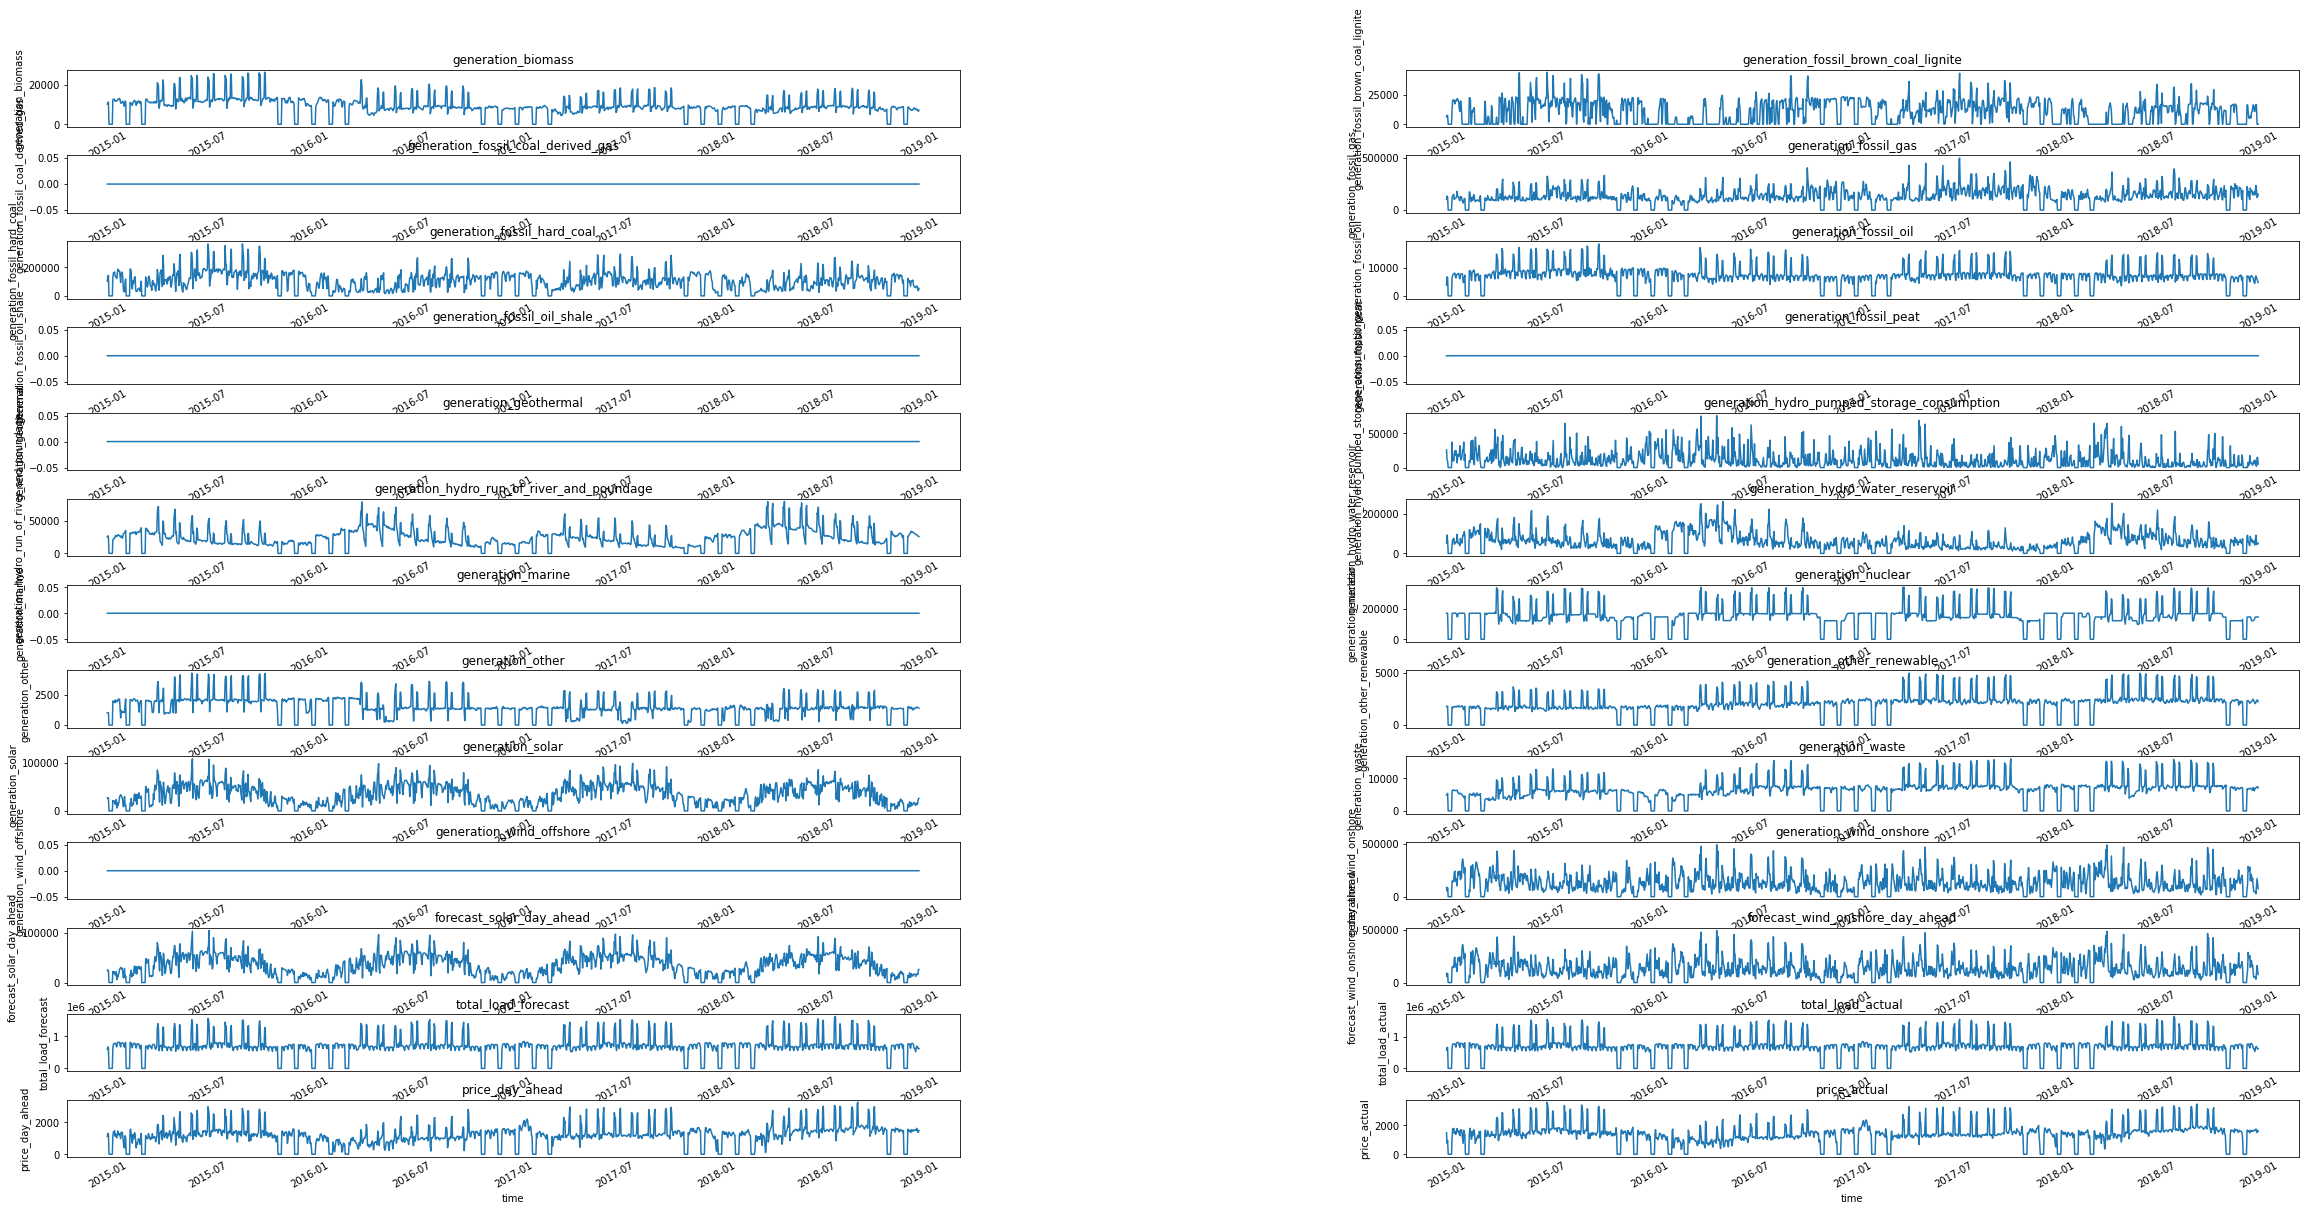

In [19]:
#Plot line charts for each feature
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(40, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
    ax = plt.subplot(nrows, ncols, i+1)
    sns.lineplot(data=energy_plot.iloc[:, i], ax=ax)
    ax.set_title(energy_plot.columns[i])
    ax.tick_params(axis='x', rotation=30, labelsize=10, length=0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

#### STEP 3: SCALING AND FEATURE SELECTION

In [20]:
#Indexing the batches
train_energy = energy.sort_values(by=['time']).copy()

#saving a copy of the time index, before resetting to numbers
date_index = train_energy.index

#rest the index and convert date-index to a number-index
train_energy = train_energy.reset_index(drop=True).copy()
train_energy.head()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal_derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_marine,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual
0,10284.0,6178.0,0.0,102162.0,101917.0,3845.0,0.0,0.0,0.0,25690.0,25149.0,52005.0,0.0,170328.0,1014.0,1775.0,27443.0,4852.0,0.0,89002.0,25200,87725,592887,573522.0,1120.86,1491.57
1,10705.0,7532.0,0.0,134010.0,133718.0,6804.0,0.0,0.0,0.0,11171.0,26796.0,92163.0,0.0,170339.0,1020.0,1822.0,26002.0,4916.0,0.0,54976.0,23466,55717,673630,660818.0,1303.73,759.03
2,11301.0,7568.0,0.0,122820.0,143917.0,6595.0,0.0,0.0,0.0,9638.0,25045.0,63699.0,0.0,170360.0,1023.0,1794.0,27558.0,5428.0,0.0,85142.0,24526,83519,636337,662615.0,1290.44,949.00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.00,0.00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.00,0.00


In [21]:
#List of features to be considered
Features = ['generation_biomass', 'generation_fossil_brown_coal_lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run_of_river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'forecast_solar_day_ahead', 'forecast_wind_onshore_day_ahead', 'total_load_forecast', 'total_load_actual', 'price_day_ahead', 'price_actual']
print('LIST OF FEATURES')
print([f for f in Features])

#Create the dataset with features and filter the data according to the list of features
data = pd.DataFrame(train_energy)
data = data[Features]

#Adding a dummy column to store prediction values after preparing data scaling
data_filtered_ext = data.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['price_actual']

#print the tail of the data frame
data_filtered_ext.tail()

LIST OF FEATURES
['generation_biomass', 'generation_fossil_brown_coal_lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run_of_river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'forecast_solar_day_ahead', 'forecast_wind_onshore_day_ahead', 'total_load_forecast', 'total_load_actual', 'price_day_ahead', 'price_actual']


,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual,Prediction
1456,7304.0,16761.0,233859.0,69578.0,7141.0,3354.0,28508.0,91163.0,145582.0,1483.0,2206.0,16162.0,7134.0,26850.0,16986,31481,691922,684773.0,1623.23,1752.71,1752.71
1457,7595.0,15748.0,193459.0,66650.0,6576.0,1944.0,27639.0,60629.0,145742.0,1437.0,2339.0,13224.0,7360.0,93264.0,17853,96193,684905,687306.0,1530.85,1666.97,1666.97
1458,6951.0,113.0,119564.0,41612.0,6124.0,14454.0,26889.0,43773.0,145737.0,1444.0,2410.0,18126.0,7458.0,172132.0,16159,159958,635083,639282.0,1369.16,1501.07,1501.07
1459,6609.0,0.0,126469.0,36607.0,5372.0,14897.0,25595.0,46509.0,145712.0,1419.0,2374.0,25256.0,7476.0,120359.0,24516,121885,607292,606334.0,1403.85,1548.59,1548.59
1460,7102.0,0.0,150191.0,52738.0,4792.0,4846.0,25506.0,50812.0,145735.0,1389.0,2241.0,26240.0,7084.0,76520.0,26440,76121,621059,621534.0,1483.08,1639.73,1639.73


In [22]:
#get the number of rows in the data
nrows = data.shape[0]

#convert the data to numpy values
np_data_unscaled = np.array(data)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

#Scale each feature between values of 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

#Creating separate column tp scale predictions
scaler_pred = MinMaxScaler()
energy_price_actual = pd.DataFrame(data_filtered_ext['price_actual'])
np_price_actual_scaled = scaler_pred.fit_transform(energy_price_actual)

(1461, 20)


#### STEP 4: TRANSFORMING THE DATA

In [26]:
#Set the sequence length to make a single prediction
sequence_length = 50

#Prediction Index
index_price_actual = data.columns.get_loc('price_actual')

#train-test split
train_data_len = math.ceil(np_data_scaled.shape[0]*0.8)

#Crete the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

#RNN Data format [samples, time steps, features]
#creating N samples, sequence_length time steps per sample and 27 features
def partition_dataset(sequence_length, np_data):
    x, y = [], []
    data_len = np_data.shape[0]
    for i in range(sequence_length, data_len):
        
        #contains sequence_length values 0-sequence_length*columns
        x.append(np_data[i-sequence_length:i, :])
        
        #prediction values for validation and single-step prediction
        y.append(np_data[i, index_price_actual])
    
    #Convert x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [27]:
#Generate training and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

#Print the shapes. The result is rows, training_sequence, features, prediction values
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1119, 50, 20) (1119,)
(292, 50, 20) (292,)


In [28]:
#check whether the input and validation data match each other
print(x_train[1][sequence_length-1][-1])
print(y_train[0])

0.4364547244585131
0.4364547244585131


#### STEP 5: TRAIN THE MULTIVARIATE PREDICTION MODEL

In [29]:
#Configure the LSTM Neural Network Model
model = Sequential()

In [30]:
#Model with n_neurons = inputshape Timestamps
n_neurons = x_train.shape[1]*x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

#create and add the LSTM layers
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))

#Add the Dense Layers
model.add(Dense(5))
model.add(Dense(1))

#Compile the model with adam optimizer
model.compile(optimizer='adam', loss='mse')

1000 50 20


In [31]:
#Training the model
epochs = 50
batch_size = 20
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

#Fit the training and validation data in the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/50
56/56 [==============================] - 177s 3s/step - loss: 0.2941 - val_loss: 0.0323
Epoch 2/50
56/56 [==============================] - 175s 3s/step - loss: 0.0238 - val_loss: 0.0278
Epoch 3/50
56/56 [==============================] - 180s 3s/step - loss: 0.0201 - val_loss: 0.0187
Epoch 4/50
56/56 [==============================] - 183s 3s/step - loss: 0.0187 - val_loss: 0.0166
Epoch 5/50
56/56 [==============================] - 182s 3s/step - loss: 0.0168 - val_loss: 0.0176
Epoch 6/50
56/56 [==============================] - 181s 3s/step - loss: 0.0155 - val_loss: 0.0189
Epoch 7/50
56/56 [==============================] - 180s 3s/step - loss: 0.0155 - val_loss: 0.0137
Epoch 8/50
56/56 [==============================] - 182s 3s/step - loss: 0.0136 - val_loss: 0.0239
Epoch 9/50
56/56 [==============================] - 176s 3s/step - loss: 0.0131 - val_loss: 0.0159
Epoch 10/50
56/56 [==============================] - 187s 3s/step - loss: 0.0127 - val_loss: 0.0180
Epoch 11/

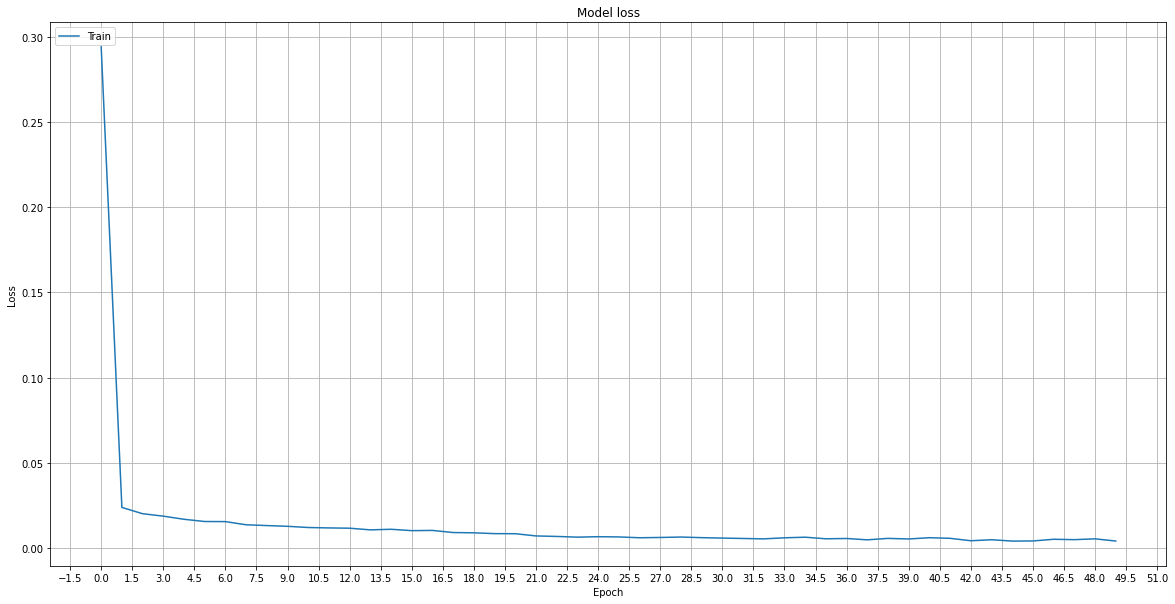

In [32]:
#Plot the loss curve for the model
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

#### STEP 6: EVALUATE MODEL PERFORMANCE

In [33]:
#Get the predicted values
y_pred_scaled = model.predict(x_test)

#Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

#Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

#Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/y_test_unscaled)))*100

#Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/y_test_unscaled)))*100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 262.93
Median Absolute Percentage Error (MDAPE): 14.47 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


#### STEP 7: PLOT THE PREDICTION OF PRESENT VALUES AND FORECAST OF FUTURE VALUES

In [61]:
#define the start date
display_start_date = pd.Timestamp('today') - pd.offsets.Day(2528)
display_start_date

Timestamp('2015-01-01 02:36:16.364314')

In [62]:
#Add the date column
data_filtered_sub = data.copy()
data_filtered_sub['time'] = date_index

In [68]:
#Add the difference between valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["price_actual"], True)

In [65]:
#Zoom in to a closer timeframe for training and validation sets
valid = valid[valid['time'].dt.date>display_start_date]
valid = train[train['time'].dt.date>display_start_date]

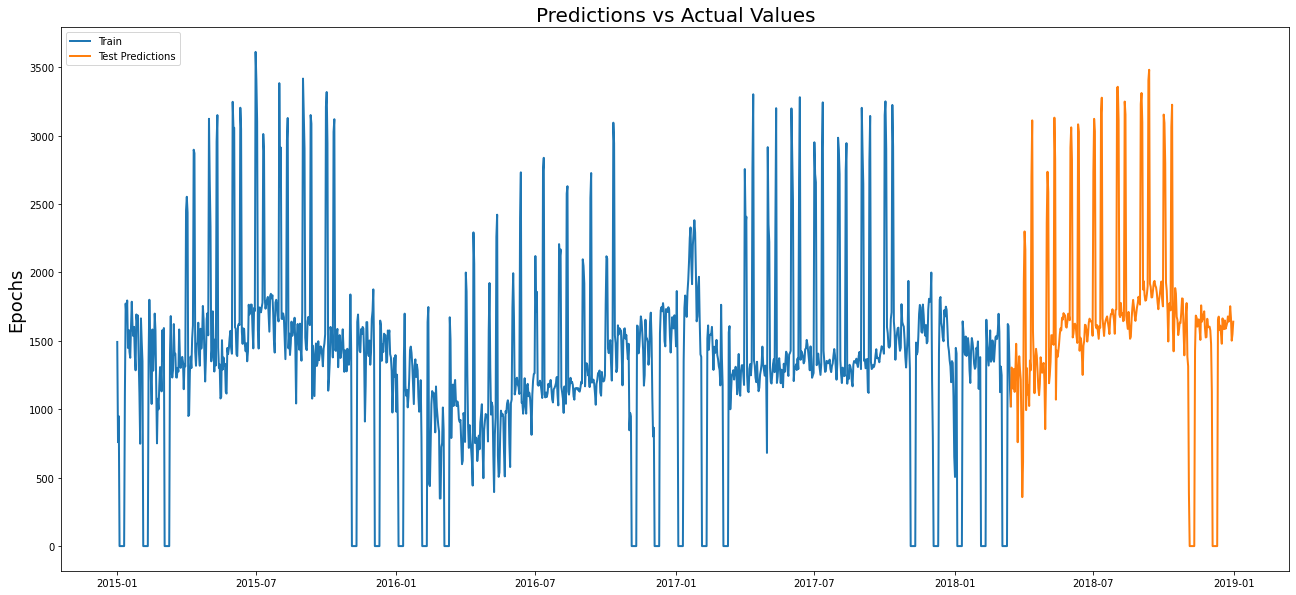

In [71]:
#Visualize the data for the training as well as the validation dataset
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['time']; yt = train[['price_actual']]
xv = valid['time']; yv = valid[['price_actual']]
plt.title('Predictions vs Actual Values', fontsize=20)
plt.ylabel('Epochs', fontsize=18)
plt.plot(xt, yt, linewidth=2.0)
plt.plot(xv, yv, linewidth=2.0)
plt.legend(['Train', 'Test Predictions', 'Actual Values'], loc='upper left')

In [69]:
#Create the bar plot with the differences
x = valid['time']
y = valid['Difference']

In [76]:
#Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = '#2BC97A'
valid.loc[y < 0, 'diff_color'] = '#C92B2B'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

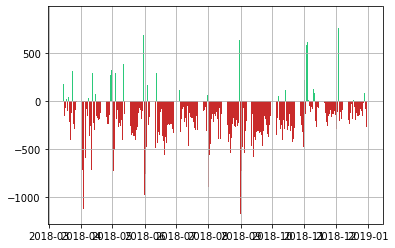

In [77]:
#display the plot
plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

#### STEP 7: PREDICT THE PRICES OF THE COMING HOURS AND DAYS

In [80]:
energy_temp = energy[-sequence_length:]
new_energy = energy_temp.filter(Features)

N = sequence_length

#Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_energy[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

#Create an empty list and append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

#Convert the X_test dataset to numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1,1))

#Print last price and predicted price for the next day
price_today = np.round(new_energy['price_actual'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today*100)/predicted_price, 2)

today = date.today() 

plus = '+'; minus=''
print(f'The energy price for {today - pd.offsets.Day(1068)} was {price_today}')
print(f'The predicted energy price is {predicted_price}({plus if change_percent > 0 else minus}{change_percent}%)')

The energy price for 2018-12-31 00:00:00 was 1639.73
The predicted energy price is 1197.0400390625(-36.98%)
